In [1]:
%run stdPackages.ipynb

# Marginal Abatement Costs - BYOC

In this exercise, we'll build our own classes to solve some of the same problems as we did in problem set 1. The notebook only contains snippet of code; it is, generally, better practice to write classes and more involved code in designated ```.py``` files. The solution classes are stored in ```/pyfiles/S2.py```.

## Q1. A Toy Model of Abatement Costs

### **Q 1.1. Define base class**

*Define a class ```MAC``` with a constructor method (```__init__```) that:*
1. *Adds a database attribute as ```self.db``` as a dictionary.*
2. *Adds values for all relevant parameters to the database.*
3. *Allow you to modify default values by passing them to the ```__init__``` method.*
4. *Add methods that allows you to compute $C(E)$, $M(E)$, $\tilde{C}(E), MAC(E) = (F'(E)-p_e)/\phi$ all on grids of $E$.*

*You should be able to get the value of a symbol x by calling ```self.db['x']```*

**Solution:**

```python
class MAC:
    def __init__(self, α = .5, γ = 1, pe = 1, ϕ = .25, γd = 100):
        """ Initialize with default values in key-value database. """
        self.db = {'α': α, 'γ': γ, 'pe': pe, 'ϕ': ϕ, 'γd': γd}
        
    def C(self, E):
        return self.db['γ'] * np.power(E, self.db['α'])-self.db['pe']*E
    
    def M(self, E):
        return self.db['ϕ']*E
    
    def Ctilde(self, E):
        return self.C(E)-self.db['γd']*np.power(self.M(E),2)/2
    
    def MAC(self, E):
        return (self.db['α']*self.db['γ']*np.power(E, self.db['α']-1)-self.db['pe'])/self.db['ϕ']
```

### **Q 1.2. Add baseline and optimal solutions as methods to the class**

*Next, define methods that allow you to compute a baseline solution and an optimal one. Note you'll have to install some additional packages if you prefer to define the class over multiple cells; otherwise you'll have to keep it in one cell (or write it directly in a py file).*

```python
    def E0(self):
        return (self.db['γ']*self.db['α']/self.db['pe'])**(1/(1-self.db['α']))
    
    def C0(self):
        return self.db['γ']*self.E0()**self.db['α']-self.db['pe']*self.E0()
    
    def M0(self):
        return self.db['ϕ']*self.E0()

    def baseSol(self):
        return {'E0': self.E0(), 'C0': self.C0(), 'M0': self.M0()}
    
    def Eopt(self, x0 = 0.5):
        return optimize.fsolve(lambda E: self.db['α']*self.db['γ']*E**(self.db['α']-1)-self.db['pe']-self.db['ϕ']*self.db['γd']*self.M(E), 
                               x0 = x0)
    
    def optSol(self, x0 = 0.5):
        Eopt = self.Eopt(x0 = x0)
        return {'Ept': Eopt, 'C': self.Ctilde(Eopt), 'M': self.M(Eopt)}    
``` 

### **Q 1.3. Plot $E^*$ as a function of $\gamma$ and $\phi$.**

**Solution:**

*Load class and initialize instance:*

In [2]:
os.chdir(d['curr'])
from pyfiles.S2 import MAC
m = MAC() # initialize

Create values of a parameter that we wish to solve the model for:

In [3]:
γGrid = np.linspace(1, 10, 100) # create some grid of values
ϕGrid = np.linspace(0.25, 2, 100)
Eγ, Eϕ = [], []
γ0, ϕ0 = m.db['γ'], m.db['ϕ']
for γ in γGrid:
    m.db['γ'] = γ
    Eγ += [m.Eopt()[0]]
m.db['γ'] = γ0 # reset value
for ϕ in ϕGrid:
    m.db['ϕ'] = ϕ
    Eϕ += [m.Eopt()[0]]
m.db['ϕ'] = ϕ0 # reset value

Plot:

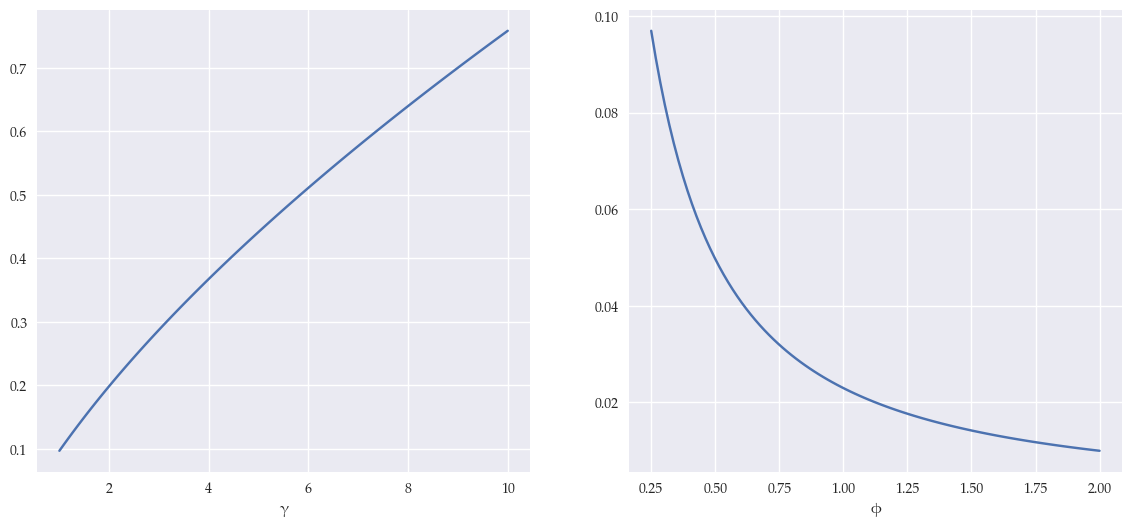

In [4]:
fig, axes = plt.subplots(1,2, figsize = (14,6))
ax = plt.subplot(1,2,1);
pd.Series(Eγ, index = pd.Index(γGrid, name = 'γ')).plot(ax=ax);
ax = plt.subplot(1,2,2);
pd.Series(Eϕ, index = pd.Index(ϕGrid, name = 'ϕ')).plot(ax=ax);
fig.savefig(os.path.join(d['figs'], "S2_Q13.pdf"),edgecolor='k') # save as pdf

## Q2. Technical abatement as a child-class

In this exercise, we'll build a class on top of the parent class from **Q1** to look a bit into inheritance. As you'll see later in the course, (almost) all of the energy system models we build are children classes of the base class ```modelShell``` from ```lpModels```.

*NB: Some of the methods in ```MAC``` changes when we go to ```MACTech``` (e.g. the way to compute $C$ and $M$). As it is best practice to make sure that the parent class (```MAC```) methods doesn't break with child classes, we've added the argument ```**kwargs``` a couple of places in the base class. This allows us to add new arguments in ```MACTech``` methods that would simply not impact the base methods.*

### **Q 2.1. Briefly explain the initial part this class**

```python
class MACTech(MAC):
    def __init__(self, α = .5, γ = 1, pe = 1, ϕ = .25, γd = 100, θ = None, c = None, σ = None):
        super().__init__(α = α, γ = γ, pe = pe, ϕ = ϕ, γd = γd) # use __init__ method from parent class
        self.initTechs(θ = θ, c = c, σ = σ)
        
    def initTechs(self, θ = None, c = None, σ = None):
        """ Initialize technologies from default values """
        if θ is None:
            self.db['Tech'] = pd.Index(['T1'], name = 'i')
            self.db['θ'] = pd.Series(0, index = self.db['Tech'], name = 'θ')
            self.db['c'] = pd.Series(1, index = self.db['Tech'], name = 'c')
            self.db['σ'] = pd.Series(1, index = self.db['Tech'], name = 'σ')
        elif isinstance(θ, pd.Series):
            self.db['θ'] = θ
            self.db['c'] = c
            self.db['σ'] = σ
            self.db['Tech'] = self.db['θ'].index
        else:
            self.db['Tech'] = 'T'+pd.Index(range(1, len(θ)+1), name = 'i').astype(str)
            self.db['θ'] = pd.Series(θ, index = self.db['Tech'], name = 'θ')
            self.db['c'] = pd.Series(c, index = self.db['Tech'], name = 'c')
            self.db['σ'] = pd.Series(1, index = self.db['Tech'], name = 'σ')
```

**Solution:**

* The class builds on the ```MAC``` class. The ```super()``` method calls the parent class and relis on this ```init``` method.
* The ```initTechs``` initializes the technology part of the class. The method allows us to add data in three ways:
    * If no data is added, the model initializes with a single technology without any abatement potential $(\theta = 0)$.
    * If data is added as ```pd.Series```, the three parameters are added directly. The ```Tech``` index is read from the relevant index.
    * We can also add data as iterables (lists, numpy arrays). In this case, we define the index as 'T' + an integer index, and add parameters as ```pd.Series```.

### **Q 2.2. Add relevant methods to the class**

1. *Add methods that determine optimal abatement and abatement costs given marginal damages.*
2. *Adjust existing methods for computing $C$, $\tilde{C}$ to this class with technical abatement (now they are functions of $M$ as well)*
3. *Add/adjust the methods that define the optimal solution for $E,M,C$. using the methods in **Q2.4** in PS1.*

**Solution:**

```python
    ### Optimal abatement functions:
    def aOpt_i(self, md, i):
        return stats.norm.cdf(
            (np.log(md/self.db['c'][i])+self.db['σ'][i]**2/2)/self.db['σ'][i]
        )
    def fOpt_i(self, md, i):
        return self.db['c'][i] * stats.norm.cdf(
            (np.log(md/self.db['c'][i])-self.db['σ'][i]**2/2)/self.db['σ'][i]
        )
    
    def aOpt_sum(self, md):
        return sum(self.db['θ'] * stats.norm.cdf(
            (np.log(md/self.db['c'])+self.db['σ']**2/2)/self.db['σ']
        ))
    
    def fOpt_sum(self, md):
        return sum(self.db['θ'] * self.db['c'] * stats.norm.cdf(
            (np.log(md/self.db['c'])-self.db['σ']**2/2)/self.db['σ']
        ))
    
    ### Adjustment to consumption functions:
    def C(self, E, M, **kwargs):
        return super().C(E)-M*self.fOpt_sum(self.db['γd'] * M)
    
    def Ctilde(self, E, M, **kwargs):
        return self.C(E,M)-self.db['γd']*M**2/2

    ### Optimum
    def FOC_RHS(self, md):
        """ Right-side of equation (7) in lecture note"""
        return md * (1-self.aOpt_sum(md)) + self.fOpt_sum(md)

    def Mopt(self, x0 = None):
        return optimize.fsolve(lambda M: self.db['α'] * self.db['γ'] * (M/(self.db['ϕ']*(1-self.aOpt_sum(self.db['γd'] * M))))**(self.db['α']-1)-self.db['pe']-self.db['ϕ']*self.FOC_RHS(self.db['γd'] * M),
                               x0 = self.M0()/2 if x0 is None else x0)
    
    def Eopt(self, x0 = None):
        Mopt = self.Mopt(x0 = x0)
        return Mopt/(self.db['ϕ']*(1-self.aOpt_sum(self.db['γd'] * Mopt)))
```

### **Q 2.3. Compute marginal abatement costs on a grid of abated emissions**

*Start with an initialization of your class:*

In [5]:
from pyfiles.S2 import MACTech
Tech = pd.Index(['T1','T2', 'T3'], name = 'i')
θ = pd.Series([0.25, 0.25, 0.25], index = Tech, name  = 'θ')
c = pd.Series([0.5, 2, 5], index = Tech, name = 'c')
σ = pd.Series([.025, .025, .025], index = Tech, name = 'σ')
mTech = MACTech(θ = θ, c= c, σ=σ)

*Finally, we want a method that allows us to replicate figure 2.2. in the lecture note with slightly different technology parameters. To do this, we need to go through a couple of steps. We start from equation (8) that defines marginal abatement costs. This equation currently depends on $E$ and technical abatement variables $a_i$ that ultimately depends on the marginal damages in optimum. To get at the MAC curve, proceed as follows:*

1. *Form a grid of marginal damages ```mdGrid``` as a linear space from 0 to 10.*
2. *For each $md_j \in$ ```mdGrid```, compute the right-hand side of eq. (7) that defines optimality given marginal damages. Define this vector ```mcGrid```.*
3. *Given the value of $mc_j\in$ ```mcGrid```, we can now back out the corresponding level of $E_j$ from (7), that is:*
    $$\begin{align}
    \dfrac{F'(E_j)-p_e}{\phi} = mc_j \qquad \Rightarrow \qquad E_j = \left(\dfrac{\alpha \gamma}{\phi mc_j+p_e}\right)^{\frac{1}{1-\alpha}}
    \end{align}$$

    *We define the vector of these $E_j$ as ```Egrid```*
4. *Next, for each $md_j\in$ ```mdGrid```, compute emissions from $M = E \phi (1-\sum_i\theta_ia_i)$ and define this vector ```Mgrid```.*
5. *Finally, exploit that $MAC = D'(M)$, to define MAC on the grid of abated emissions. (this is a pandas series with values = ```mdGrid``` and index = M0-```Mgrid```)*
6. *Plot this against the MAC-curve without technical effects. Briefly comment.*

In [6]:
mdGrid = np.linspace(np.finfo(float).eps, 10, 1000)
# Slow version, but easier syntax:
# mcGrid = np.array([md*(1-mTech.aOpt_sum(md))+mTech.fOpt_sum(md) for md in mdGrid])
# Egrid  = (mTech.db['α'] * mTech.db['γ'] / (mTech.db['ϕ'] * mcGrid+mTech.db['pe']))**(1/(1-mTech.db['α']))
# Mgrid  = Egrid * mTech.db['ϕ'] * np.array([1-mTech.aOpt_sum(md) for md in mdGrid])

# Vectorized version:
mcGrid = mTech.FOC_RHS_vec(mdGrid)
Egrid  = (mTech.db['α'] * mTech.db['γ'] / (mTech.db['ϕ'] * mcGrid+mTech.db['pe']))**(1/(1-mTech.db['α']))
Mgrid = Egrid * mTech.db['ϕ']* (1-mTech.aOpt_sum_vec(mdGrid))

# MAC curve:
MACgrid = pd.Series(mdGrid, index = pd.Index(mTech.M0()-Mgrid, name = 'Abated emissions'))

# Add MAC curve from simple model:
Egrid_notech = np.linspace(np.finfo(float).eps,1,1000)
MACnoTech = pd.Series(m.MAC(Egrid_notech), index = pd.Index(m.M0()-m.db['ϕ']*Egrid_notech, name = 'Abated emissions'))

*Fancy plot:*

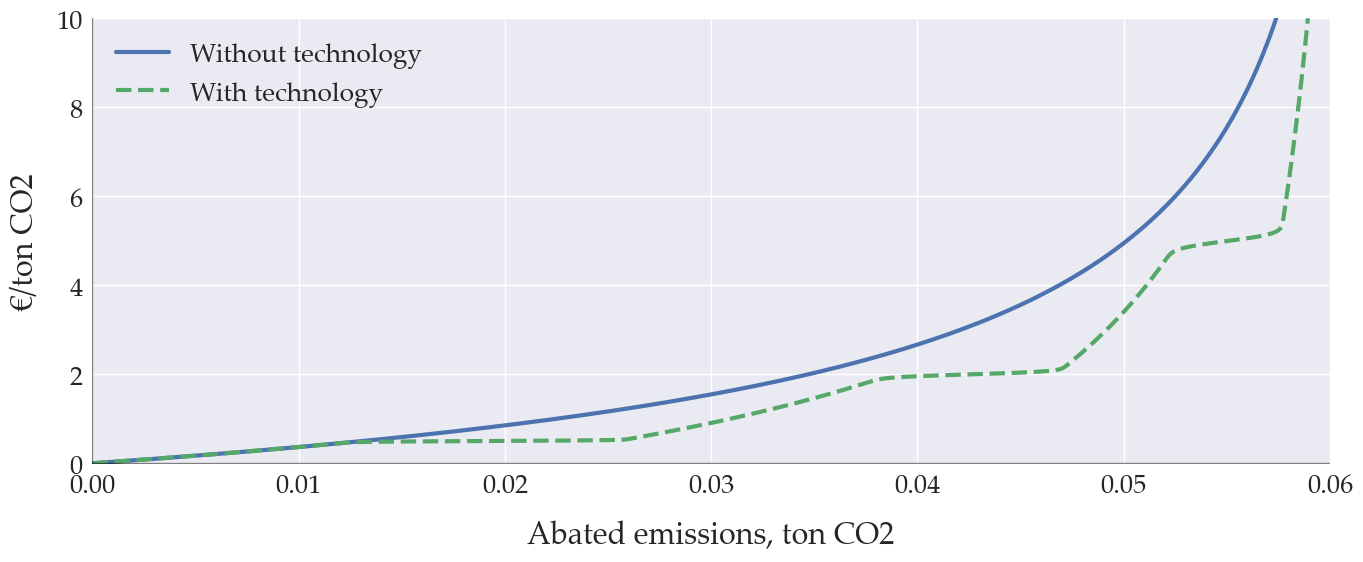

In [7]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,6)); # size of plot
seaborn.lineplot(data = MACnoTech, ax = ax, linewidth=3, label = 'Without technology');
seaborn.lineplot(data = MACgrid, ax = ax, linewidth=3, color = colors[1], linestyle = 'dashed', label = 'With technology'); 
ax.axhline(y=0, linewidth = 1, color = 'k', alpha = 0.5); # x-axis
ax.axvline(x=0, linewidth = 1, color = 'k', alpha = 0.5); # y-axis
ax.set_ylim((-0.01, 10));
ax.set_xlim((-0.00001, 0.06));
ax.set_xlabel('Abated emissions, ton CO2', labelpad = 15);
ax.set_ylabel('€/ton CO2', labelpad = 10);
fig.tight_layout(); # automatic adjustment of layout
fig.savefig(os.path.join(d['figs'], "S2_Q23.pdf"),edgecolor='k') # save as pdf

* Adding technical abatement generally lowers abatement costs. This is, naturally, the case, because it is an additional channel of abatement; we have not eliminated the potential for output reduction, only added another way to reduce emissions. 
* The three technologies are quite easy to see in the technical MAC curve: Around the cost thresholds $0.5, 2, 5$, the MAC curve becomes very flat. This is because the technologis become cost-effective around these values. 
* Note that we have used relatively small values of $\sigma$ (the dispersion of costs for each technology). If we instead increase these values, the technical abatement has a more smooth effect on the MAC curve. The following plot repeats the operation in the previous cells with larger values of $\sigma$:

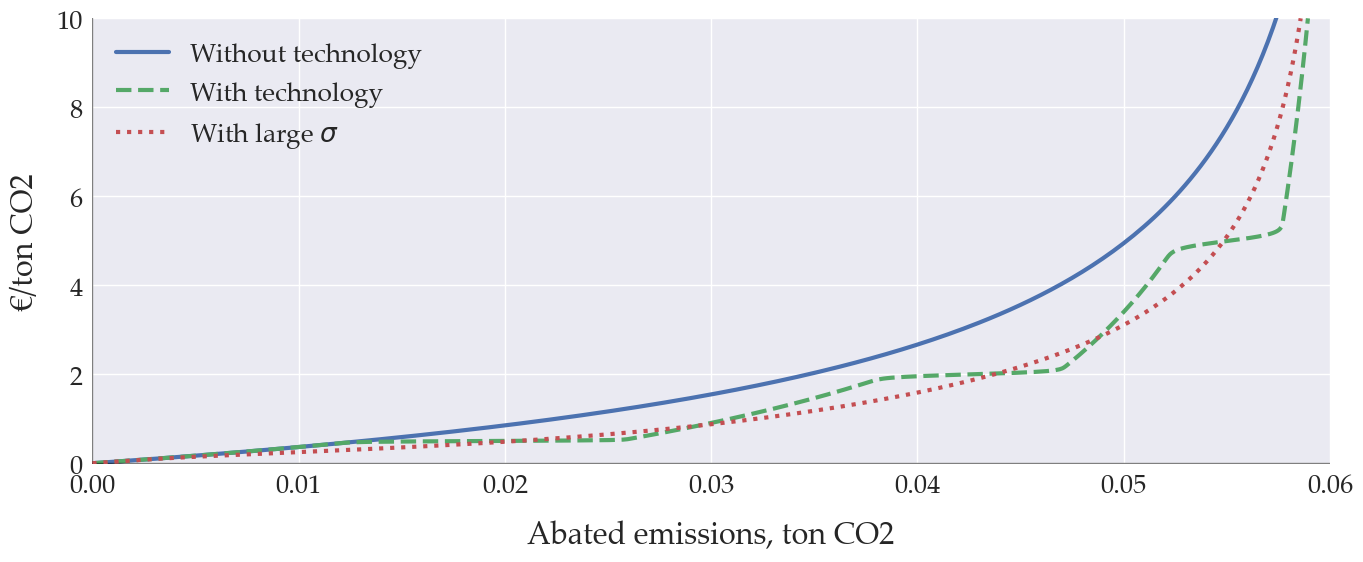

In [8]:
mTech.db['σ'] = mTech.db['σ'] * 25
mcGrid = mTech.FOC_RHS_vec(mdGrid)
Egrid  = (mTech.db['α'] * mTech.db['γ'] / (mTech.db['ϕ'] * mcGrid+mTech.db['pe']))**(1/(1-mTech.db['α']))
Mgrid = Egrid * mTech.db['ϕ']* (1-mTech.aOpt_sum_vec(mdGrid))
MACgrid = pd.Series(mdGrid, index = pd.Index(mTech.M0()-Mgrid, name = 'Abated emissions'))
seaborn.lineplot(data = MACgrid, ax = ax, linewidth=3, color = colors[2], linestyle = 'dotted', label = 'With large $\\sigma$'); 
fig